# AIB Datahack
## Data Processing

So with our exploration complete, lets clean up the data and get it ready for our machine learning models. A few things to do.
* Replace null values - Lets initially replace with the mean value of that variable
* Replace zero values in certain variables


In [47]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# data import 
df = pd.read_csv("data/training_small.txt", sep='\t', encoding='ISO-8859-1', header=0, low_memory=False, index_col=0)

df.head(3)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729


## Remove columns 
Our data exploration gave us a good insight into what columns could prove useful for machine learning algorithms, and which may not. Lets only keep the columns that we believe to be useful.

In [5]:
cols = ['Year', 'EnergyRatingCat', 'EnergyRatingCont', 'GroundFloorArea',
       'AvgWallU', 'AvgRoofU', 'AvgFloorU', 'AvgWindowU', 'AvgDoorU',
       'ExposedWallArea', 'ExposedRoofArea', 'TotFloorArea', 'TotWindowArea',
       'TotDoorArea', 'NStoreys', 'MainSHFuel', 'MainWHFuel',
       'MainSHEfficiency', 'BuildingReg', 'MainSHAdj', 'SecSHFrac',
       'SecSHEfficiency', 'MainWHEfficiency', 'MainWHAdj', 'SecSHFuel',
       'SecWHFuel', 'NChimneys', 'NOpenFlues', 'NFansVents',
       'PercDraughtStripped', 'NShelteredSides', 'PermTestResult', 'TempAdj',
       'ControlCat', 'ResponseCat', 'NCHPumps', 'NGasFans', 'DistLoss',
       'VolWaterStorage', 'TempFac', 'TempFacMult', 'HWInsulationThickness',
       'LightingEnergy', 'PumpsAndFansEnergy', 'MainWaterEnergy',
       'PrimaryLightingEnergy', 'PrimaryPumpsFansEnergy',
       'PrimaryMainWaterEnergy', 'PrimaryMainSpaceEnergy', 'LightingCO2',
       'PumpsAndFansCO2', 'MainWaterCO2', 'MainSpaceCO2', 'AreaGroundFloor',
       'HeightGroundFloor', 'AreaFirstFloor', 'HeightFirstFloor',
       'AreaSecondFloor', 'BridgingFac', 'LargestRoofTypeArea',
       'PercLowEnergy', 'TotEnergy', 'SecSpaceEnergy', 'SecWaterEnergy',
       'SecSpaceCO2', 'SecWaterCO2', 'SecSpacePrimaryEnergy',
       'SecWaterPrimaryEnergy', 'UpgradeHES', 'RoofAreaRoom', 'FirstEnerType',
       'ProdFirstEnerDelivered', 'ProdFirstEnerConvFac',
       'ProdSecondEnerDelivered', 'ProdSecondEnerConvFac',
       'ProdThirdEnerDelivered', 'ProdThirdEnerConvFac',
       'PrimaryEnergySecondarySpace', 'EnergyMainWater']

df = df[cols]
df.shape

(4999, 79)

This gives us a reduced dataframe with a mix of numerical and categorical features. Lets deal with the categorical features first.

## Processing Categorical Features

In [6]:
g = df.columns.to_series().groupby(df.dtypes).groups
dtype_dict = {k.name: v for k, v in g.items()}
dtype_dict['object']

Index(['Year', 'EnergyRatingCat', 'GroundFloorArea', 'MainSHFuel',
       'MainWHFuel'],
      dtype='object')

### Year
The 'Year' feature should already be numerical, but for some reason all values have a 'Y' at the beginning. We'll quickly remove this and finish with this feature.

In [7]:
df['Year'] = df['Year'].map(lambda x: int(float(x[1:])))
df['Year'].head(3)

BuildingID
190835    1890
523113    1901
271393    1968
Name: Year, dtype: int64

### GroundFloorArea
Similarly, the 'GroundFloorArea' feature should be numerical, but it has 'sq. m' at the end of each value. Again, we'll quickly remove this and finish with the feature.

In [8]:
df['GroundFloorArea'] = df['GroundFloorArea'].apply(lambda x: float(x[:-5]))
df['GroundFloorArea'].head(3)

BuildingID
190835     52.04
523113    147.44
271393    104.84
Name: GroundFloorArea, dtype: float64

### MainSHFuel

In [9]:
df['MainSHFuel'].head(3)

BuildingID
190835    Heating Oil                   
523113    Heating Oil                   
271393    Heating Oil                   
Name: MainSHFuel, dtype: object

In [10]:
# Lets check for null values
df['MainSHFuel'].isnull().sum()

62

In [11]:
# Ok there's some null values, this is ok, we can work with this. Ideally I'd like to assign each value to a category 
# whos median Energy Rating most closely matches the null values Energy Rating.

def closest_match(num, med_dict):
    return med_dict[min(med_dict, key=lambda x:abs(x-num))]

In [12]:
# Category median values
msf_med_dict = df.groupby(['MainSHFuel']).median()['EnergyRatingCont'].to_dict()

# invert dictionary
msf_med_dict = dict([v,k] for k,v in msf_med_dict.items())
msf_med_dict

{129.66: 'Wood Pellets (bulk supply for ',
 174.91999999999999: 'Wood Pellets (in bags for seco',
 190.91: 'Bulk LPG (propane or butane)  ',
 199.25999999999999: 'Mains Gas                     ',
 220.38999999999999: 'Heating Oil                   ',
 231.91: 'Bottled LPG                   ',
 255.12: 'Peat Briquettes               ',
 296.31: 'Electricity                   ',
 369.22000000000003: 'Solid Multi-Fuel              ',
 378.37: 'House Coal                    ',
 381.01999999999998: 'Sod Peat                      ',
 443.41000000000003: 'Manufactured Smokeless Fuel   ',
 482.64999999999998: 'Wood Logs                     '}

In [13]:
# Replace null values
df['MainSHFuel_nulls'] = df['EnergyRatingCont'].apply(lambda x: closest_match(x, msf_med_dict))
df[df['MainSHFuel'].isnull() == True].loc[:,['MainSHFuel','MainSHFuel_nulls', 'EnergyRatingCont']].head(3)

,MainSHFuel,MainSHFuel_nulls,EnergyRatingCont
BuildingID,,,
158369,NaN,Wood Pellets (bulk supply for,114.67
398941,NaN,Wood Pellets (bulk supply for,138.83
187422,NaN,Electricity,315.24


In [14]:
# Replace null values in MainSHFuel with corresponding valuse in MainSHFuel_nulls
df['MainSHFuel'].fillna(df['MainSHFuel_nulls'], inplace=True)
del df['MainSHFuel_nulls']

In [15]:
df['MainSHFuel'].head()

BuildingID
190835    Heating Oil                   
523113    Heating Oil                   
271393    Heating Oil                   
585961    Mains Gas                     
624083    Mains Gas                     
Name: MainSHFuel, dtype: object

In [16]:
# Lets check again for null values
df['MainSHFuel'].isnull().sum()

0

In [17]:
# There is a lot of black spaces around the variable names. Lets strip this off the values.
df['MainSHFuel'] = df['MainSHFuel'].apply(lambda x: x.strip())

In [18]:
# Quick count of the unique values
df['MainSHFuel'].value_counts()

Mains Gas                         1972
Heating Oil                       1902
Electricity                        682
Solid Multi-Fuel                   207
Bulk LPG (propane or butane)        89
Wood Pellets (bulk supply for       47
Manufactured Smokeless Fuel         32
House Coal                          29
Sod Peat                            13
Wood Logs                            9
Bottled LPG                          7
Wood Pellets (in bags for seco       6
Peat Briquettes                      4
Name: MainSHFuel, dtype: int64

In my exploration notebook, I rolled up the under represented categories into their own seperate 'Other' column. For now, having replaced the nulls with it's closest corresponding category, the under represented categories have bulked up slightly so I'm going to leave them be. I may revisit this further down the line if the model needs improving.

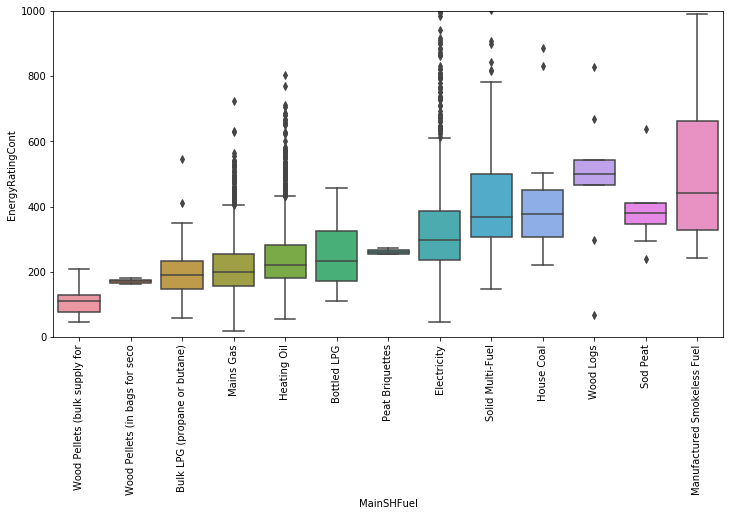

In [19]:
# Ok lets plot the values 
new_MainSHFuel_sort = df.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
new_MainSHFuel_sort = sorted(new_MainSHFuel_sort, key=new_MainSHFuel_sort.get)

var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=new_MainSHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

Actually, having looked at the graph, theres one final change I'm going to make: roll the two 'Wood Pellets' cateogries into one.

In [20]:
# Combine 'Wood Pellets' categories
replace_list = ['Wood Pellets (in bags for seco', 'Wood Pellets (bulk supply for']   
df['MainSHFuel'].replace(replace_list, 'Wood Pellets', inplace=True)

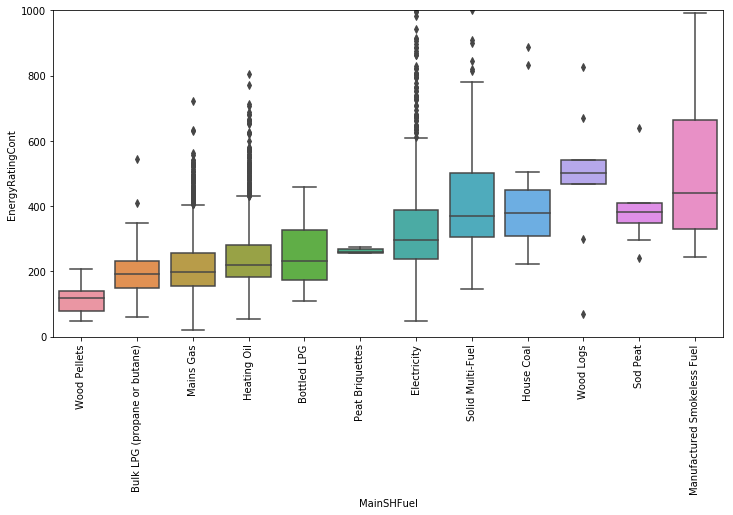

In [21]:
# Ok lets plot the values 
new_MainSHFuel_sort = df.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
new_MainSHFuel_sort = sorted(new_MainSHFuel_sort, key=new_MainSHFuel_sort.get)

var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=new_MainSHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

Ok, I'm really happy with how this has turned out. Lets convert the categories to numerical values and close off this variable.

In [22]:
df['MainSHFuel_cat'] = df['MainSHFuel'].astype('category').cat.codes

### MainWHFuel

The final categorical variable to work with is 'MainWHFuel'. I'll process this very similarly to 'MainSHFuel'.

In [23]:
df['MainWHFuel'].head(3)

BuildingID
190835    Heating Oil                   
523113    Heating Oil                   
271393    Heating Oil                   
Name: MainWHFuel, dtype: object

In [24]:
# Lets check for null values
df['MainWHFuel'].isnull().sum()

62

In [25]:
# 62 null values ones again - Lets use the same method above to assign categories to these rows

# Category mean values
mwf_med_dict = df.groupby(['MainWHFuel']).median()['EnergyRatingCont'].to_dict()

# invert dictionary
mwf_med_dict = dict([v,k] for k,v in mwf_med_dict.items())
mwf_med_dict

{129.66: 'Wood Pellets (bulk supply for ',
 147.66: 'Bottled LPG                   ',
 174.91999999999999: 'Wood Pellets (in bags for seco',
 190.91: 'Bulk LPG (propane or butane)  ',
 198.82499999999999: 'Mains Gas                     ',
 220.125: 'Heating Oil                   ',
 255.12: 'Peat Briquettes               ',
 299.66000000000003: 'Electricity                   ',
 354.37: 'Sod Peat                      ',
 363.53499999999997: 'Solid Multi-Fuel              ',
 381.46000000000004: 'House Coal                    ',
 391.68000000000001: 'Manufactured Smokeless Fuel   ',
 482.64999999999998: 'Wood Logs                     ',
 1508.3399999999999: 'Anthracite                    '}

In [26]:
# Replace null values
df['MainWHFuel_nulls'] = df['EnergyRatingCont'].apply(lambda x: closest_match(x, mwf_med_dict))
df[df['MainWHFuel'].isnull() == True].loc[:,['MainWHFuel','MainWHFuel_nulls', 'EnergyRatingCont']].head(3)

,MainWHFuel,MainWHFuel_nulls,EnergyRatingCont
BuildingID,,,
158369,NaN,Wood Pellets (bulk supply for,114.67
398941,NaN,Bottled LPG,138.83
187422,NaN,Electricity,315.24


In [27]:
# Replace null values in MainSHFuel with corresponding valuse in MainSHFuel_nulls
df['MainWHFuel'].fillna(df['MainWHFuel_nulls'], inplace=True)
del df['MainWHFuel_nulls']

In [28]:
# Lets check again for null values
df['MainWHFuel'].isnull().sum()

0

In [29]:
# There is a lot of black spaces around the variable names. Lets strip this off the values.
df['MainWHFuel'] = df['MainWHFuel'].apply(lambda x: x.strip())

In [30]:
# Quick count of the unique values
df['MainWHFuel'].value_counts()

Mains Gas                         1959
Heating Oil                       1889
Electricity                        732
Solid Multi-Fuel                   194
Bulk LPG (propane or butane)        89
Wood Pellets (bulk supply for       43
House Coal                          27
Manufactured Smokeless Fuel         26
Wood Logs                           10
Bottled LPG                          9
Sod Peat                             9
Wood Pellets (in bags for seco       6
Peat Briquettes                      5
Anthracite                           1
Name: MainWHFuel, dtype: int64

In [31]:
# Lets combine the 'Wood Pellets' categories again
replace_list = ['Wood Pellets (in bags for seco', 'Wood Pellets (bulk supply for']   
df['MainWHFuel'].replace(replace_list, 'Wood Pellets', inplace=True)

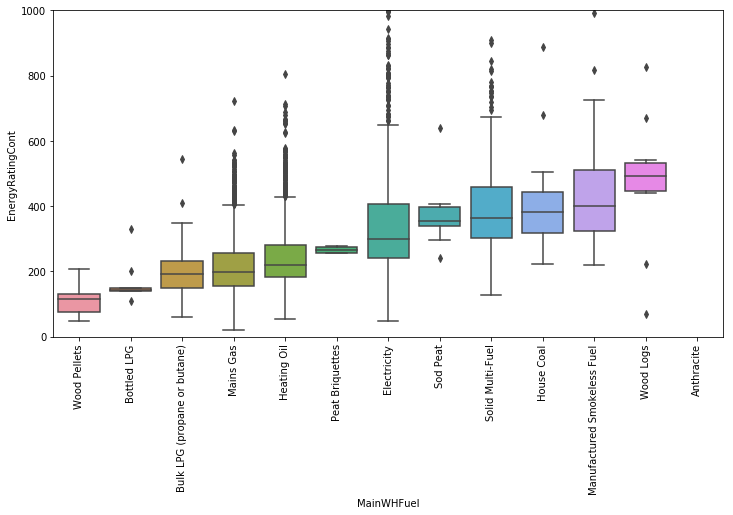

In [32]:
# Ok lets plot the values 
new_MainWHFuel_sort = df.groupby(['MainWHFuel']).mean().to_dict()['EnergyRatingCont']
new_MainWHFuel_sort = sorted(new_MainWHFuel_sort, key=new_MainWHFuel_sort.get)

var = 'MainWHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=new_MainWHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

In [33]:
df['MainWHFuel_cat'] = df['MainWHFuel'].astype('category').cat.codes

In [34]:
df.loc[:,['MainWHFuel', 'MainWHFuel_cat']].head()

,MainWHFuel,MainWHFuel_cat
BuildingID,,
190835,Heating Oil,4
523113,Heating Oil,4
271393,Heating Oil,4
585961,Mains Gas,6
624083,Mains Gas,6


### Final Look at Categorical Features

In [35]:
g = df.columns.to_series().groupby(df.dtypes).groups
dtype_dict = {k.name: v for k, v in g.items()}
dtype_dict['object']

Index(['EnergyRatingCat', 'MainSHFuel', 'MainWHFuel'], dtype='object')

## Processing Numerical Features

In [36]:
g = df.columns.to_series().groupby(df.dtypes).groups
dtype_dict = {k.name: v for k, v in g.items()}
dtype_dict['float64']

Index(['EnergyRatingCont', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU',
       'AvgFloorU', 'AvgWindowU', 'AvgDoorU', 'ExposedWallArea',
       'ExposedRoofArea', 'TotFloorArea', 'TotWindowArea', 'TotDoorArea',
       'NStoreys', 'MainSHEfficiency', 'BuildingReg', 'MainSHAdj', 'SecSHFrac',
       'SecSHEfficiency', 'MainWHEfficiency', 'MainWHAdj', 'SecSHFuel',
       'SecWHFuel', 'NChimneys', 'NOpenFlues', 'NFansVents',
       'PercDraughtStripped', 'NShelteredSides', 'PermTestResult', 'TempAdj',
       'ControlCat', 'ResponseCat', 'NCHPumps', 'NGasFans', 'DistLoss',
       'VolWaterStorage', 'TempFac', 'TempFacMult', 'HWInsulationThickness',
       'LightingEnergy', 'PumpsAndFansEnergy', 'MainWaterEnergy',
       'PrimaryLightingEnergy', 'PrimaryPumpsFansEnergy',
       'PrimaryMainWaterEnergy', 'PrimaryMainSpaceEnergy', 'LightingCO2',
       'PumpsAndFansCO2', 'MainWaterCO2', 'MainSpaceCO2', 'AreaGroundFloor',
       'HeightGroundFloor', 'AreaFirstFloor', 'HeightFirstFloor',
       'Ar

### Dealing with Null values
Ok first off, lets count the null values in each column.

In [38]:
null_df = df.isnull().sum().reset_index()
null_df.columns = ['index', 'count']
null_df['percentage'] = null_df['count'].apply(lambda x: (x/4999)*100)
null_df.set_index('index', inplace=True)
null_df.sort_values(by=['percentage'], ascending=False).head(10)

,count,percentage
index,,
MainSHEfficiency,608,12.162432
PrimaryMainSpaceEnergy,543,10.862172
PrimaryEnergySecondarySpace,517,10.342068
LargestRoofTypeArea,517,10.342068
SecSpacePrimaryEnergy,517,10.342068
GroundFloorArea,502,10.042008
AvgWallU,486,9.721944
HWInsulationThickness,465,9.301860
TempFac,465,9.301860


Luckily, of the 81 columns, no column has more than 12% of missing data. This is pretty ok to start with. We have a lot of correct data in nearly every column, so in the interest of time, lets replace null values with that variable mean. I'll revisit this further when attempting to improve the machine learning model in future notebooks.

In [39]:
# replace null values with column mean
df.fillna(df.mean(), inplace=True).head()

,Year,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,...,ProdFirstEnerDelivered,ProdFirstEnerConvFac,ProdSecondEnerDelivered,ProdSecondEnerConvFac,ProdThirdEnerDelivered,ProdThirdEnerConvFac,PrimaryEnergySecondarySpace,EnergyMainWater,MainSHFuel_cat,MainWHFuel_cat
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,1890,F,418.42,52.04,2.10,2.30,0.61,2.71,3.00,32.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,2335.6809,3,4
523113,1901,G,520.35,147.44,2.01,0.75,0.94,2.63,3.96,211.22,...,0.0,0.0,0.0,0.0,0.0,0.0,7144.838,4470.0759,3,4
271393,1968,D2,281.33,104.84,0.38,0.13,0.68,2.81,0.00,94.41,...,0.0,0.0,0.0,0.0,0.0,0.0,2127.347,5837.4729,3,4
585961,2002,C2,188.17,95.31,0.55,0.26,0.34,2.80,3.03,89.50,...,0.0,0.0,0.0,0.0,0.0,0.0,2771.886,3769.6248,5,6
624083,2002,B3,134.95,283.87,0.55,0.26,0.41,3.10,3.01,254.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5296.5828,5,6


In [40]:
# Final null check
df.isnull().sum().sum()

0

### Dealing with zero values

Another thing found during the initial exploration of the data is that some numerical variables had a high portion of zero values in thier column. But logic tells you that 'GroundFloorArea' or 'AvgWallU' can never have values of zero. This makes me believe that these values are errors and that they should be replaced. 

The variables I'm talking about here are area related variables, so lets isolate these first.

In [41]:
df.columns

Index(['Year', 'EnergyRatingCat', 'EnergyRatingCont', 'GroundFloorArea',
       'AvgWallU', 'AvgRoofU', 'AvgFloorU', 'AvgWindowU', 'AvgDoorU',
       'ExposedWallArea', 'ExposedRoofArea', 'TotFloorArea', 'TotWindowArea',
       'TotDoorArea', 'NStoreys', 'MainSHFuel', 'MainWHFuel',
       'MainSHEfficiency', 'BuildingReg', 'MainSHAdj', 'SecSHFrac',
       'SecSHEfficiency', 'MainWHEfficiency', 'MainWHAdj', 'SecSHFuel',
       'SecWHFuel', 'NChimneys', 'NOpenFlues', 'NFansVents',
       'PercDraughtStripped', 'NShelteredSides', 'PermTestResult', 'TempAdj',
       'ControlCat', 'ResponseCat', 'NCHPumps', 'NGasFans', 'DistLoss',
       'VolWaterStorage', 'TempFac', 'TempFacMult', 'HWInsulationThickness',
       'LightingEnergy', 'PumpsAndFansEnergy', 'MainWaterEnergy',
       'PrimaryLightingEnergy', 'PrimaryPumpsFansEnergy',
       'PrimaryMainWaterEnergy', 'PrimaryMainSpaceEnergy', 'LightingCO2',
       'PumpsAndFansCO2', 'MainWaterCO2', 'MainSpaceCO2', 'AreaGroundFloor',
       'Height

In [42]:
area_vars = ['GroundFloorArea','AvgWallU', 'AvgRoofU', 'AvgFloorU', 'AvgWindowU', 'AvgDoorU',
       'ExposedWallArea', 'ExposedRoofArea', 'TotFloorArea', 'TotWindowArea',
       'TotDoorArea','VolWaterStorage', 'HWInsulationThickness','AreaGroundFloor',
       'HeightGroundFloor', 'AreaFirstFloor', 'HeightFirstFloor',
       'AreaSecondFloor', 'LargestRoofTypeArea', 'RoofAreaRoom']

for var in area_vars:
    print(var)
    df[var].replace(0, df[var].mean(), inplace=True)

GroundFloorArea
AvgWallU
AvgRoofU
AvgFloorU
AvgWindowU
AvgDoorU
ExposedWallArea
ExposedRoofArea
TotFloorArea
TotWindowArea
TotDoorArea
VolWaterStorage
HWInsulationThickness
AreaGroundFloor
HeightGroundFloor
AreaFirstFloor
HeightFirstFloor
AreaSecondFloor
LargestRoofTypeArea
RoofAreaRoom


#### Lets plot a few of these variables to see the updated graph

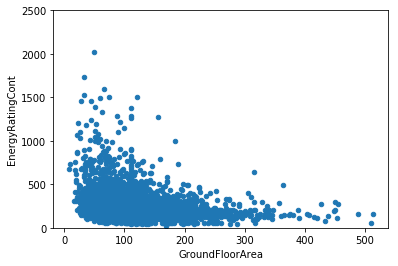

In [43]:
var = 'GroundFloorArea'
df.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

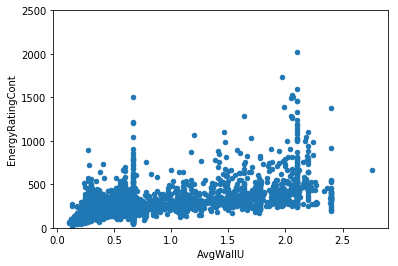

In [44]:
var = 'AvgWallU'
df.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

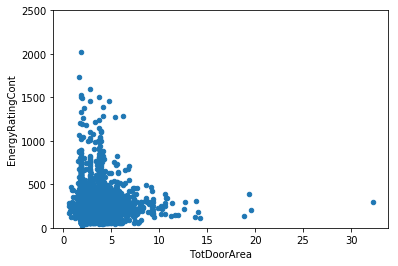

In [45]:
var = 'TotDoorArea'
df.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

## Outliers
### Dependant Variable

In [48]:
df['EnergyRatingCont'].head()

BuildingID
190835    418.42
523113    520.35
271393    281.33
585961    188.17
624083    134.95
Name: EnergyRatingCont, dtype: float64

In [49]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df['EnergyRatingCont'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.5852234 ]
 [-1.404719  ]
 [-1.4041224 ]
 [-1.4035258 ]
 [-1.40332693]
 [-1.3993496 ]
 [-1.39504083]
 [-1.39490825]
 [-1.39298588]
 [-1.38960515]]

outer range (high) of the distribution:
[[  7.50959978]
 [  7.94180274]
 [  7.96586558]
 [  8.20583103]
 [  8.23221397]
 [  8.28783027]
 [  8.40390196]
 [  8.90391837]
 [  9.80929078]
 [ 11.65775393]]


Data standardization means converting data values to have mean of 0 and a standard deviation of 1, which is what we have done here. Some comments:

* The low values look ok and are close to zero
* There are some very high values, the 11.66 an obvious stand out

For now I'm not going to remove any of these but this is an interesting observation and one I may revisit later.

### Independant Variables

We have a lot of independant variables in this data set so I'm going to look for outliers in the 4 most correlated features (plus GroundFloorArea) with 'EnergyRatingCont'. These are:

* AvgWallU 
* AvgRoofU 
* AvgWindowU 
* AvgFloorU
* GroundFloorArea

#### AvgWallU

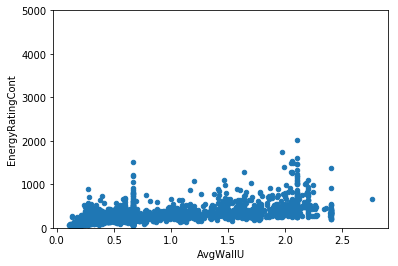

In [52]:
var = 'AvgWallU'
data = pd.concat([df['EnergyRatingCont'], df[var]], axis=1)
data.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,5000));

**Obervations**

There is an overall positive linear trend in the data here with a number of spikes along the x-axis. There is one specific outlier, where the AvgWallU value is over 2.5, but this follows the overall linear trend so I'll leave it in. With regards t othe spikes, I'm not 100% sure whats causing them so I'll leave them here for now.

#### AvgRoofU

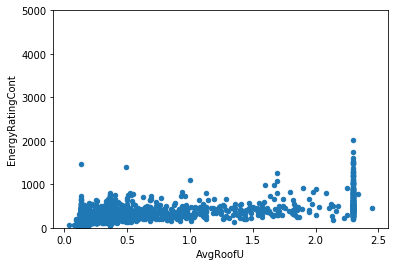

In [53]:
var = 'AvgRoofU'
data = pd.concat([df['EnergyRatingCont'], df[var]], axis=1)
data.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,5000));

**Observations**

Again there's clearly a positive linear relationship evident in the data with one large spike towards the end of the data.

#### AvgWindowU

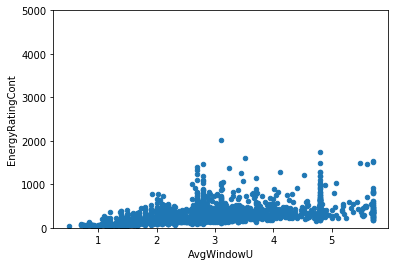

In [54]:
var = 'AvgWindowU'
data = pd.concat([df['EnergyRatingCont'], df[var]], axis=1)
data.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,5000));

**Observations**

Once again there's clearly a positive linear relationship evident in the data with a few small spikes. Theres no evident outliers so no changes needed.

#### AvgFloorU

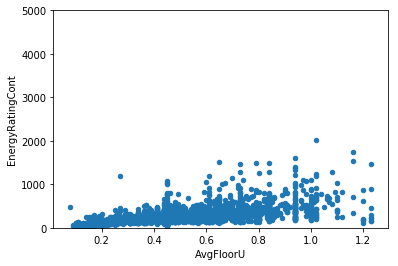

In [56]:
var = 'AvgFloorU'
data = pd.concat([df['EnergyRatingCont'], df[var]], axis=1)
data.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,5000));

**Observations**

Ctrl-C, Ctrl-V from above!

#### GroundFloorArea

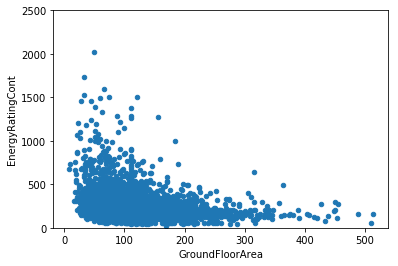

In [59]:
var = 'GroundFloorArea'
data = pd.concat([df['EnergyRatingCont'], df[var]], axis=1)
data.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

**Observations**

Theres clearly a trend evident here where in general the higher the GroundFloorArea, the lower the Energy Rating value its given. There's no evident outliers so I'll leave it as is.

## Conclusion

In this notebook, our data set has been cleaned and is now ready to be used from a machine learning perspective. All null values in the data set were replaces, along with zero values in area type values (which make no sense if you think about it). We've also searched for some outliers, but fortunately (our unfortunately, I'm not sure yet) we found none in the end. The final step I'll do in this notebook is to save this data frame to a csv so that this processing won't need to be completed again in the next notebook.

In [ ]:
df.to_csv('data/training_small_processed.csv')